In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi=False
import os

#import sklearn for cross validation|
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score,cross_validate

#import keras modules
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import keras
import keras.layers
from keras.layers import Layer 
import keras.initializers
from keras.models import Model, Sequential,load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Embedding, Lambda, Flatten, Multiply, multiply,dot, add,subtract
from keras.layers import Concatenate,concatenate,LeakyReLU,maximum,minimum
from keras.optimizers import Adam
from keras.regularizers import l2,l1
from keras.preprocessing import sequence
from keras.engine.topology import Layer, InputSpec

from keras.utils import plot_model
from IPython.display import SVG


from sklearn.metrics import precision_recall_curve, auc, roc_curve

#import rdkit
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

#fix the random seed
np.random.seed(5)

import pickle
import random



Using TensorFlow backend.


In [2]:
GeneExpression_with_Symbol=pd.read_csv('/DAS_Storage4/ijjin/Study_2/CellLine/CCLE_expression_zscore.csv',index_col=0)
valid_gene_list=GeneExpression_with_Symbol.columns

In [3]:
GeneSet_List=[]
GeneSetFile='/DAS_Storage1/ijjin/Personal_studies/Drug-Cancer_reponse/geneset/c2.cp.kegg.v7.5.1.symbols.gmt'
with open(GeneSetFile) as f:
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter='\t')) #reads csv into a list of lists
    for row in data:
        GeneSet_List.append(row)

GeneSet_Dic={}
for GeneSet in GeneSet_List:
    GeneSet_Dic[GeneSet[0]]=GeneSet[2:]
GeneSet_Dic_withoutNA={}
for GeneSet in GeneSet_Dic:
    GeneSet_tmp=pd.Series(GeneSet_Dic[GeneSet])
    GeneSet_tmp=GeneSet_tmp[GeneSet_tmp.isin(valid_gene_list)]
    GeneSet_Dic_withoutNA[GeneSet]=GeneSet_tmp




In [4]:
NCI60=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/221031_NCI60_median_with_raw_parameter.csv',index_col=0)

In [5]:
NCI60_randomized=NCI60.sample(frac=1)
NCI60_randomized=NCI60_randomized.reset_index(drop=True)

In [6]:
K.clear_session()
def get_session(gpu_fraction=0.1):

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    return tf.Session(config=tf.ConfigProto(allow_soft_placement=True,gpu_options=gpu_options))

KTF.set_session(get_session())


2022-11-09 14:38:05.362758: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-09 14:38:05.399877: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299915000 Hz
2022-11-09 14:38:05.404901: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d4518f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-09 14:38:05.404969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-09 14:38:05.411761: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-09 14:38:05.523695: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1d4538a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-09 14:38:05.523751: I tensorflow/compiler/xla/service/s

In [7]:
X_origin=[pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/CellLine/Input/'+str(x)+'.csv',index_col=0) for x in range(len(GeneSet_Dic_withoutNA))]
Drug=pd.read_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Drug/NCI60_compound_Morgan512.csv',index_col=0)


In [8]:
NCI60_filtered=NCI60_randomized

In [9]:
def pick_up_balanced(df,ratio_list,filter_list):
    #df: NCI60_filtered
    #ratio: [training_ratio,validation_ratio,test_ratio]
    #filter_list: [] (empty): Unseen combination (Drug-Cell line-Concentration)/['NSC','CellName']: Unseen Pair/['NSC']: Unseen Drug/['CellName']: Unseen Cell line
    if sum(ratio_list)!=1:
        ratio_list=[0.8,0.1,0.1]
        
    if len(filter_list)==0:
        test_Response_list=range(0,int(len(NCI60_filtered)*1/10))
        training_Response_list=range(int(len(NCI60_filtered)*1/10),int(len(NCI60_filtered)*9/10))
        validation_Response_list=range(int(len(NCI60_filtered)*9/10),(len(NCI60_filtered)))
        return [test_Response_list,training_Response_list,validation_Response_list]
    
    else:
        identifier_df=NCI60_filtered[filter_list+['CONCENTRATION']].groupby(by=filter_list).count().reset_index()
        identifier_df.columns=filter_list+['count']
        identifier_df=identifier_df.sort_values(by='count')
        len_df=len(identifier_df)

        test_idx=np.arange(0,len_df,10)
        training_idx=[]
        for i in np.arange(1,9,1):
            training_idx.extend(np.arange(i,len_df,10))
        training_idx=np.sort(training_idx)
        validation_idx=np.arange(9,len_df,10)

        test_pair_df=identifier_df.iloc[test_idx]
        training_pair_df=identifier_df.iloc[training_idx]
        validation_pair_df=identifier_df.iloc[validation_idx]

        NCI60_filtered_with_index=NCI60_filtered[filter_list].reset_index()

        test_df=pd.merge(test_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        training_df=pd.merge(training_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)
        validation_df=pd.merge(validation_pair_df,NCI60_filtered_with_index,how='inner',on=filter_list)

        test_Response_list=test_df['index']
        training_Response_list=training_df['index']
        validation_Response_list=validation_df['index']


        return [test_Response_list,training_Response_list,validation_Response_list]

In [10]:
#Unseen Drug
test_Response_list,training_Response_list,validation_Response_list=pick_up_balanced(NCI60_filtered,[0.8,0.1,0.1],['NSC'])

In [11]:
#relu
def Making_Model():
    #model_parameter=load_model('/DAS_Storage4/ijjin/Study_2/Single/NCI60_March22/Parameter/Model/220507_training_validation.hdf5',compile=False)

    #Make Model for each gene set, that consists of multiple genes_attention by built-in(2019/05/08)
    initializer = tf.keras.initializers.he_uniform()

    #Drug level
    Drug_feature_length=512
    Drug_Input=Input((Drug_feature_length,), dtype='float32', name='Drug_Input')
    Drug_Input=Input((Drug_feature_length,), dtype='float32')

    Drug_Dense1=Dense(256, name='Drug_Dense_1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense1=BatchNormalization()(Drug_Dense1)
    Drug_Dense1=Activation('relu', name='Drug_RELU_1')(Drug_Dense1)

    Drug_Dense2=Dense(128, name='Drug_Dense_2',kernel_initializer=initializer)(Drug_Dense1)
    Drug_Dense2=BatchNormalization()(Drug_Dense2)
    Drug_Dense2=Activation('relu', name='Drug_RELU_2')(Drug_Dense2)

    Drug_Dense_New1=Dense(128, name='Drug_Dense_New1',kernel_initializer=initializer)(Drug_Input)
    Drug_Dense_New1=BatchNormalization()(Drug_Dense_New1)
    Drug_Dense_New1=Activation('relu', name='Drug_RELU_New1')(Drug_Dense_New1)

    Drug_Dense_New2=Dense(32, name='Drug_Dense_New2',kernel_initializer=initializer)(Drug_Dense_New1)
    Drug_Dense_New2=BatchNormalization()(Drug_Dense_New2)
    Drug_Dense_New2=Activation('relu', name='Drug_RELU_New2')(Drug_Dense_New2)
    
    #Gene level
    GeneSet_Model=[]
    GeneSet_Input=[]
    for GeneSet in GeneSet_Dic_withoutNA.keys():
        Gene_Input=Input(shape=(len(GeneSet_Dic_withoutNA[GeneSet]),),dtype='float32', name=GeneSet+'_Input')
        
        Drug_effected_Model_for_Attention=[Gene_Input]
        Drug_Dense_Geneset=Dense(int(len(GeneSet_Dic_withoutNA[GeneSet])/4)+1,dtype='float32',name=GeneSet+'_Drug',kernel_initializer=initializer)(Drug_Dense_New2)
        Drug_Dense_Geneset=BatchNormalization(name=GeneSet+'_Drug_Batch')(Drug_Dense_Geneset)
        Drug_Dense_Geneset=Activation('relu', name=GeneSet+'Drug_RELU')(Drug_Dense_Geneset)
        Drug_effected_Model_for_Attention.append(Drug_Dense_Geneset) #Drug feature to attention layer
        Gene_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1,name=GeneSet+'_Concat')
        Gene_Attention = Dense(len(GeneSet_Dic_withoutNA[GeneSet]), activation='tanh', name=GeneSet+'_Attention_Dense',kernel_initializer=initializer)(Gene_Concat)
        Gene_Attention=Activation(activation='softmax', name=GeneSet+'_Attention_Softmax')(Gene_Attention)
        Attention_Dot=dot([Gene_Input,Gene_Attention],axes=1,name=GeneSet+'_Dot')
        Attention_Dot=BatchNormalization(name=GeneSet+'_BatchNormalized')(Attention_Dot)
        Attention_Dot=Activation('relu',name=GeneSet+'_RELU')(Attention_Dot)
        GeneSet_Model.append(Attention_Dot)
        GeneSet_Input.append(Gene_Input)

    Drug_effected_Model_for_Attention=GeneSet_Model.copy()
    
    
    Drug_Dense_Sample=Dense(int(len(GeneSet_Dic_withoutNA)/16)+1,dtype='float32',name='Sample_Drug_Dense',kernel_initializer=initializer)(Drug_Dense_New2)
    Drug_Dense_Sample=BatchNormalization(name=GeneSet+'Sample_Drug_Batch')(Drug_Dense_Sample)
    Drug_Dense_Sample=Activation('relu', name='Sample_Drug_ReLU')(Drug_Dense_Sample)    #Drug feature to attention layer
    Drug_effected_Model_for_Attention.append(Drug_Dense_Sample)
    
    GeneSet_Concat=concatenate(GeneSet_Model,axis=1, name='GeneSet_Concatenate')
    Drug_effected_Concat=concatenate(Drug_effected_Model_for_Attention,axis=1, name='Drug_effected_Concatenate')
    Sample_Attention=Dense(len(GeneSet_Dic_withoutNA.keys()),activation='tanh', name='Sample_Attention_Dense',kernel_initializer=initializer)(Drug_effected_Concat)
    Sample_Attention=Activation(activation='softmax', name='Sample_Attention_Softmax')(Sample_Attention)
    Sample_Multiplied=multiply([GeneSet_Concat,Sample_Attention], name='Sample_Attention_Multiplied')
    Sample_Multiplied=BatchNormalization(name='Sample_Attention_BatchNormalized')(Sample_Multiplied)
    Sample_Multiplied=Activation('relu',name='Sample_Attention_Relu')(Sample_Multiplied)
    
    Input_for_model=[]
    for GeneSet_f in GeneSet_Input:
        Input_for_model.append(GeneSet_f)
    Input_for_model.append(Drug_Input)
    
    Dose_Input=Input((1,), dtype='float32', name='Dose_Input')
    Input_for_model.append(Dose_Input)

    Total_model=[Sample_Multiplied,Drug_Dense2]
    Model_Concat=concatenate(Total_model,axis=1, name='Total_Concatenate')
    Concated=Dense(128, name='Total_Dense')(Model_Concat)
    Concated=BatchNormalization(name='Total_BatchNormalized')(Concated)
    Concated=Activation(activation='relu', name='Total_RELU')(Concated)
    
    Final=Dense(32, name='Output_Dense1',kernel_initializer=initializer)(Concated)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU')(Final)
    Final=Dense(8,name='Output_Dense2',kernel_initializer=initializer)(Final)
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU2')(Final)
    Final=Dense(2, name='Output_Dense3',kernel_initializer=initializer)(Final)    
    Final=BatchNormalization()(Final)
    Final=Activation(activation='relu',name='Output_RELU3')(Final)
    
    Final_y_max=Dense(1, name='y_max',kernel_initializer=initializer)(Final)
    Final_y_min=Dense(1, name='y_min',kernel_initializer=initializer)(Final)
    Final_slope=Dense(1, name='slope',kernel_initializer=initializer)(Final)
    Final_IC50=Dense(1, name='IC50',kernel_initializer=initializer)(Final)

    Final_1=subtract([Dose_Input,Final_IC50],name='Final_1')
    Final_2=multiply([Final_slope,Final_1],name='Final_2')
    Final_negative=Lambda(lambda x:-1*x)(Final_2)
    Final_Sigmoid=Activation(activation='sigmoid',name='Final_Sigmoid')(Final_negative)
    Final_scale=subtract([Final_y_max,Final_y_min],name='Final_scale')
    Final_scale=Activation(activation='relu',name='Final_scale_activation')(Final_scale)
    Final_3=multiply([Final_scale,Final_Sigmoid],name='Final_3')
    Final_4=add([Final_3,Final_y_min],name='Final_4')
    model=Model(inputs=Input_for_model,outputs=Final_4)

    return model


In [12]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0005, factor=0.1, patience=10, min_lr=0, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0005, restore_best_weights=True)


In [13]:
class HiDRA_DataGenerator(keras.utils.Sequence):
    def __init__(self, idxs, batch_size=1024, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.idxs = idxs
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.idxs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        idxs_tmp = [self.idxs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(idxs_tmp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.idxs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # Generate data
        NCI60_float_gen=NCI60_filtered.iloc[idxs_tmp]
        X_origin_tmp=[df.loc[NCI60_float_gen['CellName']] for df in X_origin]
        X_origin_tmp.append(Drug.loc[NCI60_float_gen['NSC']])
        Dose_df=pd.DataFrame(NCI60_float_gen['CONCENTRATION'])
        X_origin_tmp.append(Dose_df)
        Y_origin_tmp=NCI60_float_gen['AVERAGE_GIPRCNT']

        return X_origin_tmp, Y_origin_tmp

In [14]:
training_generator=HiDRA_DataGenerator(training_Response_list)
validation_generator=HiDRA_DataGenerator(validation_Response_list)
test_generator=HiDRA_DataGenerator(test_Response_list)

In [15]:
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r 

def aggregated_loss(y_true,y_pred):
    mse_value=tf.keras.metrics.mse(y_true,y_pred)
    pearson_loss=plcc_loss(y_true,y_pred)
    return mse_value+pearson_loss
    
    
def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den


In [97]:
NCI60_filtered.iloc[test_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Drug/Split_by_Drug_Test.csv')

In [94]:
NCI60_filtered.iloc[training_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Drug/Split_by_Drug_Training.csv')

In [96]:
NCI60_filtered.iloc[validation_Response_list].to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Training/Split_by_Drug/Split_by_Drug_Validation.csv')

In [16]:
#test
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])


In [19]:
NCI60_filtered

,NSC,CellName,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope
0,4518,KM12,1.0000,1.034569,2.049053,5,2.099319,8.219485e-01,-0.278687,3.000000
1,674102,UACC257,-2.0000,1.952976,1.952976,5,1.912630,1.000310e-01,1.030786,2.092798
2,666660,OVCAR4,-2.0000,2.040612,2.078281,5,2.079099,3.622170e-17,1.283848,3.000000
3,699491,NIHOVCAR3,1.3979,1.071269,1.996271,12,1.976040,2.916764e-01,0.074183,1.000000
4,701758,786O,0.0000,2.026348,2.026348,5,1.978109,1.325838e+00,1.626795,3.000000
...,...,...,...,...,...,...,...,...,...,...
4737369,147811,HCT116,-2.0000,2.024697,2.078496,5,2.081552,6.362993e-01,0.525233,1.960788
4737370,732731,NIHOVCAR3,-2.0000,1.978422,1.978422,5,1.998067,8.412381e-31,1.550210,3.000000
4737371,689184,A498,2.0000,1.332236,2.096231,5,2.003508,6.697522e-01,2.000000,3.000000
4737372,660812,KM12,0.0000,1.990000,2.022000,5,2.013793,1.427302e+00,1.033655,3.000000


In [24]:
#New dataset(GIPRCNT) on New model with MinMax_Training whole dataset (y_max=2)
hist=model2.fit_generator(generator=training_generator, steps_per_epoch=len(training_Response_list) // 1024, epochs=2000,verbose=1,validation_data=validation_generator,use_multiprocessing=True,workers=10,callbacks=[reduce_lr,es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000






2022-11-07 13:22:11.571025: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


3701/3701 [==============================] - 3822s 1s/step - loss: 0.1970 - plcc_metric: 0.8782 - mean_squared_error: 0.0752 - val_loss: 0.2563 - val_plcc_metric: 0.8398 - val_mean_squared_error: 0.0961
Epoch 2/2000
3701/3701 [==============================] - 3548s 959ms/step - loss: 0.1103 - plcc_metric: 0.9322 - mean_squared_error: 0.0426 - val_loss: 0.2548 - val_plcc_metric: 0.8406 - val_mean_squared_error: 0.0954
Epoch 3/2000
3701/3701 [==============================] - 3799s 1s/step - loss: 0.0969 - plcc_metric: 0.9406 - mean_squared_error: 0.0375 - val_loss: 0.2529 - val_plcc_metric: 0.8415 - val_mean_squared_error: 0.0944
Epoch 4/2000
3701/3701 [==============================] - 3734s 1s/step - loss: 0.0901 - plcc_metric: 0.9448 - mean_squared_error: 0.0349 - val_loss: 0.2491 - val_plcc_metric: 0.8444 - val_mean_squared_error: 0.0935
Epoch 5/2000
3701/3701 [==============================] - 3438s 929ms/step - loss: 0.0857 - plcc_metric: 0.9476 - mean_squared_error: 0.0332 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3135/3701 [========================>.....] - ETA: 8:52 - loss: 0.0786 - plcc_metric: 0.9520 - mean_squared_error: 0.0306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3772s 1s/step - loss: 0.0769 - plcc_metric: 0.9531 - mean_squared_error: 0.0299 - val_loss: 0.2501 - val_plcc_metric: 0.8439 - val_mean_squared_error: 0.0940
Epoch 10/2000
1671/3701 [============>.................] - ETA: 33:05 - loss: 0.0752 - plcc_metric: 0.9541 - mean_squared_error: 0.0293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3786s 1s/step - loss: 0.0745 - plcc_metric: 0.9545 - mean_squared_error: 0.0290 - val_loss: 0.2557 - val_plcc_metric: 0.8400 - val_mean_squared_error: 0.0957
Epoch 12/2000
 904/3701 [======>.......................] - ETA: 45:52 - loss: 0.0727 - plcc_metric: 0.9556 - mean_squared_error: 0.0283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3432s 927ms/step - loss: 0.0726 - plcc_metric: 0.9556 - mean_squared_error: 0.0283 - val_loss: 0.2538 - val_plcc_metric: 0.8413 - val_mean_squared_error: 0.0951
Epoch 14/2000
 196/3701 [>.............................] - ETA: 52:44 - loss: 0.0697 - plcc_metric: 0.9576 - mean_squared_error: 0.0272

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3389s 916ms/step - loss: 0.0718 - plcc_metric: 0.9561 - mean_squared_error: 0.0280 - val_loss: 0.2524 - val_plcc_metric: 0.8416 - val_mean_squared_error: 0.0940

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 15/2000
1572/3701 [===========>..................] - ETA: 31:19 - loss: 0.0660 - plcc_metric: 0.9596 - mean_squared_error: 0.0256

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3406s 920ms/step - loss: 0.0636 - plcc_metric: 0.9611 - mean_squared_error: 0.0247 - val_loss: 0.2526 - val_plcc_metric: 0.8415 - val_mean_squared_error: 0.0941
Epoch 17/2000
 557/3701 [===>..........................] - ETA: 46:37 - loss: 0.0626 - plcc_metric: 0.9617 - mean_squared_error: 0.0243

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3374/3701 [==========================>...] - ETA: 4:47 - loss: 0.0626 - plcc_metric: 0.9617 - mean_squared_error: 0.0243

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3409s 921ms/step - loss: 0.0623 - plcc_metric: 0.9619 - mean_squared_error: 0.0242 - val_loss: 0.2570 - val_plcc_metric: 0.8390 - val_mean_squared_error: 0.0959
Epoch 20/2000
2483/3701 [===================>..........] - ETA: 17:52 - loss: 0.0618 - plcc_metric: 0.9622 - mean_squared_error: 0.0240

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3701/3701 [==============================] - 3398s 918ms/step - loss: 0.0618 - plcc_metric: 0.9622 - mean_squared_error: 0.0240 - val_loss: 0.2582 - val_plcc_metric: 0.8381 - val_mean_squared_error: 0.0963
Epoch 22/2000
3701/3701 [==============================] - 3365s 909ms/step - loss: 0.0616 - plcc_metric: 0.9623 - mean_squared_error: 0.0240 - val_loss: 0.2578 - val_plcc_metric: 0.8382 - val_mean_squared_error: 0.0960
Epoch 23/2000
3701/3701 [==============================] - 3602s 973ms/step - loss: 0.0614 - plcc_metric: 0.9625 - mean_squared_error: 0.0239 - val_loss: 0.2580 - val_plcc_metric: 0.8382 - val_mean_squared_error: 0.0962
Epoch 24/2000
3701/3701 [==============================] - 3703s 1s/step - loss: 0.0613 - plcc_metric: 0.9625 - mean_squared_error: 0.0238 - val_loss: 0.2574 - val_plcc_metric: 0.8385 - val_mean_squared_error: 0.0959

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Restoring model weights from the end of the best epoch
E

In [20]:
pd.DataFrame(hist.history)

NameError: name 'hist' is not defined

In [25]:
pd.DataFrame(hist.history).to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221107_Full_by_Drug_Training_and_Validation.csv')

In [98]:
model2.save('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221107_Trained_Model.hdf5')

In [ ]:
#test
model2=Making_Model()
model2.compile(loss=aggregated_loss,optimizer=keras.optimizers.Adam(lr=0.01),metrics=[plcc_metric,'mean_squared_error'])

In [22]:
model2.load_weights('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221107_Trained_Model.hdf5')

In [23]:
model2.evaluate_generator(test_generator)

[0.25383300772864065, 0.8420241214496232, 0.0958571285815724]

In [102]:
test_idx=test_generator.indexes
predicted_tmp=model2.predict_generator(test_generator)
predicted_tmp=[x[0] for x in predicted_tmp]

In [103]:
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values

In [104]:
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [105]:
test_df['predicted']=predicted_tmp

In [107]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221107_test_df.csv')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


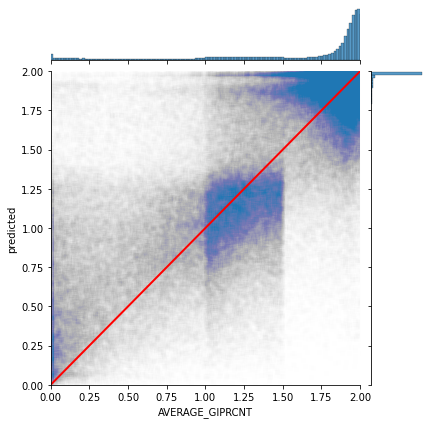

In [108]:
#new_full
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted,alpha=0.002)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221108_NCI60_split_by_dru|g_full.pdf')

In [109]:
NCI60_randomized_level_list=[]
scale=0.1
for i in range(int(2/scale)):
    NCI60_randomized_level_df=test_df[(test_df.AVERAGE_GIPRCNT>i*scale)*(test_df.AVERAGE_GIPRCNT<(i+1)*scale)]
    NCI60_randomized_level_list.append(NCI60_randomized_level_df)
len_min=min([len(df) for df in NCI60_randomized_level_list])
NCI60_randomized_level_list_new=[]
for df in NCI60_randomized_level_list:
    scale_each=len_min/len(df)
    df_new=df.sample(frac=scale_each)
    NCI60_randomized_level_list_new.append(df_new)
NCI60_balanced=pd.concat(NCI60_randomized_level_list_new)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


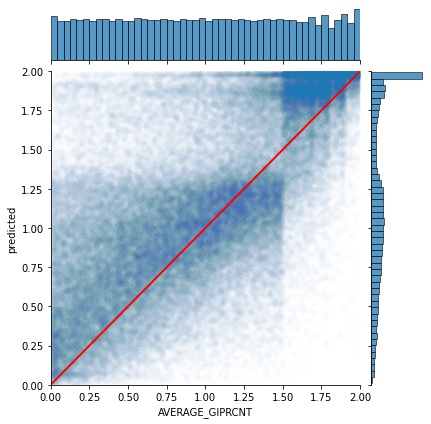

In [110]:
#new_scaled
plot=sns.jointplot(NCI60_balanced.AVERAGE_GIPRCNT,NCI60_balanced.predicted,alpha=0.01)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221108_NCI60_Split_by_Drug_scaled.pdf')

In [66]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
Drug_Dense_New1 (Dense)         (None, 128)          65664       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128)          512         Drug_Dense_New1[0][0]            
__________________________________________________________________________________________________
Drug_RELU_New1 (Activation)     (None, 128)          0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
Drug_Dense

In [70]:
model_parameter=Model(inputs=model2.inputs,outputs=[model2.get_layer('y_max').output,model2.get_layer('y_min').output,model2.get_layer('IC50').output,model2.get_layer('slope').output])

In [85]:
test_idx=test_generator.indexes
test_parameter=model_parameter.predict_generator(test_generator)
test_y_max=[x[0] for x in test_parameter[0]]
test_y_min=[x[0] for x in test_parameter[1]]
test_IC50=[x[0] for x in test_parameter[2]]
test_slope=[x[0] for x in test_parameter[3]]

In [86]:
test_idx_df=pd.DataFrame({'idx':test_Response_list})
test_idx_new=test_idx_df.iloc[test_idx].idx.values
test_df=NCI60_filtered.iloc[test_idx_new]
test_df=test_df.iloc[0:len(predicted_tmp)]

In [87]:
test_df['y_max_predicted']=test_y_max
test_df['y_min_predicted']=test_y_min
test_df['IC50_predicted']=test_IC50
test_df['slope_predicted']=test_slope

In [88]:
def response(x,y_max,y_min,IC50,slope):
    return (y_min+((y_max-y_min)/(1+np.exp(slope*(x-IC50)))))

#The function for the response curve

In [89]:
test_df['predicted_from_parameter']=[response(x.CONCENTRATION,x.y_max_predicted,x.y_min_predicted,x.IC50_predicted,x.slope_predicted) for idx,x in test_df.iterrows()]

In [92]:
test_df.corr()

,NSC,CONCENTRATION,AVERAGE_GIPRCNT,Viability_max,count,y_max,y_min,IC50,slope,y_max_predicted,y_min_predicted,IC50_predicted,slope_predicted,predicted_from_parameter
NSC,1.000000,-0.021268,0.042000,0.037321,-0.155333,-0.007348,0.012202,0.044454,0.036793,-0.009461,-0.002946,0.019267,0.015344,0.022128
CONCENTRATION,-0.021268,1.000000,-0.703220,0.001760,0.007488,0.001215,-0.007862,0.092756,0.004127,-0.027724,0.004123,0.040192,0.024329,-0.753811
AVERAGE_GIPRCNT,0.042000,-0.703220,1.000000,0.106160,-0.026726,-0.038145,0.123684,0.239152,0.026409,-0.179125,0.110846,0.152291,0.020974,0.841856
Viability_max,0.037321,0.001760,0.106160,1.000000,0.022712,0.667910,-0.063992,0.178195,0.149330,-0.073987,-0.014562,0.139865,0.106284,0.034656
count,-0.155333,0.007488,-0.026726,0.022712,1.000000,-0.016577,0.055272,-0.081841,-0.138093,0.006365,0.066394,-0.095108,-0.114520,-0.020924
y_max,-0.007348,0.001215,-0.038145,0.667910,-0.016577,1.000000,-0.058906,-0.247231,0.022197,0.143326,-0.100303,-0.107047,0.002000,-0.045349
y_min,0.012202,-0.007862,0.123684,-0.063992,0.055272,-0.058906,1.000000,-0.269703,-0.098599,-0.199893,0.371570,-0.146170,-0.377570,0.031713
IC50,0.044454,0.092756,0.239152,0.178195,-0.081841,-0.247231,-0.269703,1.000000,0.063759,-0.382141,0.051308,0.561042,0.344284,0.113726
slope,0.036793,0.004127,0.026409,0.149330,-0.138093,0.022197,-0.098599,0.063759,1.000000,0.030127,-0.161942,0.157139,0.228282,0.013943
y_max_predicted,-0.009461,-0.027724,-0.179125,-0.073987,0.006365,0.143326,-0.199893,-0.382141,0.030127,1.000000,-0.792548,-0.628630,0.163949,-0.282423


In [99]:
test_df.to_csv('/DAS_Storage4/ijjin/Study_2/220921_Final/Single/NCI60_March22/Result/221107_Split_by_Drug/221107_test_df_by_parameter.csv')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


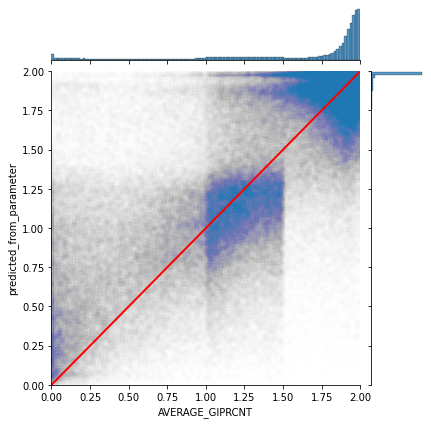

In [101]:
#new_full
plot=sns.jointplot(test_df.AVERAGE_GIPRCNT,test_df.predicted_from_parameter,alpha=0.002)
plot.ax_joint.set_xlim(0,2)
plot.ax_joint.set_ylim(0,2)
plot.ax_joint.plot([0,2], [0,2], 'r', linewidth = 2)
#plot.savefig('/DAS_Storage4/ijjin/Study_2/220921_Final/Figure/221108_NCI60_split_by_drug_full.pdf')